Hi there! 
This project consists in *a ML regression inferring unemployment searches in Google Spain*. Although I believe the idea can be achieved, this is just a sketch to learn ML techniques and automations in Google Cloud Platform.

This jupyter is **out**dated, but I think it fairly explains the data processing before applying ML.
To get a better view of the ML part:  https://github.com/albertovpd/automated_ML_regression/blob/master/testing_ml.ipynb 


=> https://datastudio.google.com/s/p1KU6ucP7lI

# PART I

-----------------------

# Creating the dataset to play with.

- Merge 4 datasets with different lenght by date
- Google searches dataset:
    - There are 3 columns: Date, keywords, and score, grouped by week. It needs to be structured like a column for each keyword, and rows with the score (the score will be the trend index of Google Trends).
    
- Spanish news (3 datasets):
    - There are 3 columns: Date, keyword and sentiment. The same keyword can appear many times the same day.
    - A column counting occurrences per day of a keyword must be created, also a column with mean sentiment per day.
    - Then a column called score will be created, multiplying occurrences * mean.
    - Then the final datset will be Date, as much columns as keywords, every column will have the score mentioned above as rows. Everything grouped by week.

In [1]:
import pandas as pd

In [2]:
df_political=pd.read_csv("./input/dashboard_spanish_news_political.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_political.sort_values(by=["Date"],inplace=True)

df_economical=pd.read_csv("./input/dashboard_spanish_news_economical.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_economical.sort_values(by=["Date"],inplace=True)

df_social=pd.read_csv("./input/dashboard_spanish_news_social.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_social.sort_values(by=["Date"],inplace=True)

df_google=pd.read_csv("./input/data_pytrends.csv",index_col=[0])
df_google.sort_values(by=["date"],inplace=True)

# Dataset previews:

- With news, I need to count occurrences, calculate the average of sentiment, multiply both to create a new column.


In [3]:
datasets_raw=[df_political, df_social, df_economical, df_google]
for d in datasets_raw:
    
    display(d.tail())
    column_list= d.columns
    print("Unique keywords: ", d[column_list[0]].unique(),"\n","\n",
         "Shape: ", d.shape,"\n","\n"
         )

,political,Date,Sentiment
55731,juicio,2020-12-20,-4.49
55735,juicio,2020-12-20,-1.08
55734,juicio,2020-12-20,-8.04
55732,juicio,2020-12-20,-6.47
55773,ejercito,2020-12-20,-1.78


Unique keywords:  ['juicio' 'ejercito' 'vigilancia' 'protestas' 'inestabilidad_politica'
 'seguridad_nacional' 'corrupcion' 'refugiados' 'rebelion' 'terrorismo'
 'extremismo' 'precio_petroleo'] 
 
 Shape:  (55899, 3) 
 



,social,Date,Sentiment
42788,emergencia_sanitaria,2020-12-20,-4.60
42787,emergencia_sanitaria,2020-12-20,-4.65
42786,emergencia_sanitaria,2020-12-20,-2.00
42797,emergencia_sanitaria,2020-12-20,-3.45
42877,enfermedades_muy_infecciosas,2020-12-20,-0.14


Unique keywords:  ['enfermedades_muy_infecciosas' 'vacunas' 'emergencia_sanitaria'
 'inmigracion' 'agresion_sexual' 'ciencia' 'emprendimiento'
 'precio_vivienda' 'energias_renovables' 'censura_en_medios' 'subsidios'
 'racismo'] 
 
 Shape:  (42878, 3) 
 



,economical,Date,Sentiment
100,stock_market,2020-12-20,-4.16
99,stock_market,2020-12-20,-1.71
98,stock_market,2020-12-20,-2.56
966,incertidumbre_economica,2020-12-20,-5.53
950,incertidumbre_economica,2020-12-20,-2.92


Unique keywords:  ['pobreza' 'incertidumbre_economica' 'stock_market'
 'macroeconomia_deuda_y_vulnerabilidad' 'desempleo'
 'job_quality_&_labor_market_performance' 'libre_comercio'
 'inflacion_economica' 'precio_petroleo' 'quiebra_economica'
 'crecimiento_economico' 'banco_mundial' 'finanzas_y_bancos'
 'prosperidad_economica_y_finanzas'] 
 
 Shape:  (160349, 3) 
 



,keyword,date,trend_index
7139,yoga,2020-12-13,39
5915,examenes,2020-12-13,33
2243,podemos,2020-12-13,18
917,comparecencia,2020-12-13,4
8261,en familia,2020-12-13,62


Unique keywords:  ['zoom' 'yoga' 'crisis economica' 'badi' 'erte' 'vox' 'examenes'
 'refugiados' 'estado de alarma' 'psoe' 'idealista' 'paro' 'menu escolar'
 'meetic' 'uber' 'autonomo' 'bullying' 'hipoteca' 'sepe' 'taxi' 'hangouts'
 'corrupcion' 'tinder' 'en casa' 'clases online' 'piso barato' 'infeccion'
 'videollamada' 'pandemia' 'negocio online' 'crisis politica'
 'productividad' 'independentismo' 'videoconferencia' 'medico'
 'coronavirus' 'emprendimiento' 'cursos online' 'residencia ancianos'
 'skype' 'en familia' 'meditacion' 'barometro' 'remoto' 'desescalada'
 'comparecencia' 'teletrabajo' 'formacion' 'embarazo' 'pp' 'nacionalismo'
 'amazon' 'just eat' 'inmigracion' 'comedor social' 'compartir piso'
 'steam' 'mas pais' 'desempleo' 'uber eats' 'banco alimentos'
 'manifestacion' 'caritas' 'cruz roja' 'hbo' 'hacer deporte' 'pnv'
 'deshaucio' 'ayuda alquiler' 'podemos' 'disney' 'glovo' 'netflix'
 'deliveroo' 'bildu' 'ciudadanos' 'cabify' 'erc' 'divorcio' 'protesta'
 'compromis'] 
 
 

With Google searches, what we have is the Trending index. Score 100 means that from the requested period of time, in this week the maximum of occurrences were reached, and everything else get normalize by that peak. It is not possible to request the real number of occurrences.

# Data Processing

### Working with the Google dataset: 

- Creating a column for each keyword with the trend_index value.

I'm going to create a dataframe with the set of dates, and append the score of keywords to this dataset (kind of get dummies, but I can't do that, I have already the units I want for each column)

In [4]:
# creating df
df_google_dates=pd.DataFrame()

# creating the Date column in new dataset
df_google_dates["date"]=list(set(df_google["date"]))
df_google_dates["date"]=pd.to_datetime(df_google_dates["date"])
df_google_dates.sort_values(by=["date"],inplace=True)
df_google_dates.tail()

,date
28,2020-11-15
92,2020-11-22
95,2020-11-29
32,2020-12-06
52,2020-12-13


In [5]:
# dates are a pain in the ass, you know right?
df_google_dates.date.dtypes

dtype('<M8[ns]')

 - append to the empty dataframe with dates

In [6]:
# Creating the new columns. Trend index with the name of the corresponding keyword
keyword_list=list(set(df_google["keyword"]))
keyword_list.sort()
for k in keyword_list:
    df_google_dates[k]=df_google[(df_google['keyword'] == k)]["trend_index"].tolist()
#df_google_dates.index=df_google_dates["date"]
#df_google_dates.drop(columns="date",inplace=True)
df_google_dates.tail()

,date,amazon,autonomo,ayuda alquiler,badi,banco alimentos,barometro,bildu,bullying,cabify,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
28,2020-11-15,81,49,27,26,100,47,47,31,7,...,23,16,82,46,76,10,7,8,42,23
92,2020-11-22,98,42,21,39,37,35,22,20,8,...,23,12,66,49,89,10,7,7,42,20
95,2020-11-29,85,54,22,17,14,25,18,22,11,...,34,15,76,37,81,7,7,7,34,18
32,2020-12-06,90,31,21,41,10,33,10,23,10,...,28,12,98,48,82,10,8,7,39,16
52,2020-12-13,88,44,25,31,14,13,6,18,13,...,28,10,79,35,57,9,9,6,39,18


**This will be our target in the ML regression"**: Unemployment

In [7]:
df_google_dates.rename(columns={'desempleo':"unemployment"}, inplace=True)

### Working with news datasets. 

I'll need to:

- Create a column for each keyword.
- Count occurrences of that keyword.
- Measure average sentiment.
- Group data by week, starting on sunday, to merge with the Google dataset.
- Combine occurrences and sentiment into one column representative of both, for each keyword.

In [8]:
# let's pplay with the 1st dataset and a random keyword, for instance
df_political[df_political["political"]=="juicio"].head()

,political,Date,Sentiment
15784,juicio,2019-01-01,-6.08
15773,juicio,2019-01-01,0.18
15774,juicio,2019-01-01,0.18
15775,juicio,2019-01-01,-1.20
15776,juicio,2019-01-01,-1.20


- So, I need to measure the average of sentiment of each keyword per day

In [9]:
df_political[df_political["political"]=="juicio"].groupby("Date").mean().head()

,Sentiment
Date,
2019-01-01,-2.930000
2019-01-02,-3.986667
2019-01-03,-2.350000
2019-01-04,-4.822500
2019-01-05,-4.723333


- Also, counting occurrences of that keyword

In [10]:
df_political[df_political["political"]=="juicio"].groupby("Date").count().head()

,political,Sentiment
Date,,
2019-01-01,14,14
2019-01-02,18,18
2019-01-03,40,40
2019-01-04,16,16
2019-01-05,60,60


- Let's use an aggregate to perform both

In [11]:
df2=df_political[df_political["political"]=="juicio"].groupby(["Date"]).agg(['count','mean'])
# erase multiindex
df2.columns=df2.columns.droplevel(0)
df2.tail()

,count,mean
Date,,
2020-12-16,21,-5.710952
2020-12-17,13,-4.783077
2020-12-18,12,-8.670833
2020-12-19,8,-5.951250
2020-12-20,11,-3.266364


- Great, now let's resample by week, starting on Sunday, like the Google Searches dataset

In [12]:
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample('W-SUN').mean() #weekly totals
# score is how we are going to measure the keywords
df2["score"]=df2["count"]*df2["mean"]
df2.tail()

,count,mean,score
Date,,,
2020-11-22,9.000000,-4.722266,-42.500395
2020-11-29,17.000000,-5.013151,-85.223565
2020-12-06,20.285714,-4.461923,-90.513293
2020-12-13,9.428571,-5.743085,-54.149087
2020-12-20,14.857143,-5.962872,-88.591243


ok, now I know how to do it, then let's continue creating a function to perform this for every keyword in every Spanish news datasets.

- I need to create an empty dataframe.
- loop for each keyword from a set of keywords.
- perform what i did before for all keywords.
- concat to the mepty dataframe.
- put all this in a function.

In [13]:
# pending of erasing this and writing it in a separate script
def creating_dataset(df,column):
    '''
    Column is the column in which are allocated the keywords, for every case: political, social and economical columns
    '''
    df["Date"]=pd.to_datetime(df["Date"])
    # list of new columns
    list_keywords=list(set(df[column]))
    # creating empty dataframe to append info
    df_final=pd.DataFrame()
    df_final["date"]=list(set(df["Date"]))
    
    for k in list_keywords:
        # creating a new dataframe for every keyword in the column, getting the occurrences of keyword and mean of sentiment
        df4=pd.DataFrame()
        df4=df[df[column]==k].groupby(["Date"]).agg(['count','mean'])
        # erase multiindex
        df4.columns=df4.columns.droplevel(0)
        # this will be our score, occurrences * mean 
        df4[k]=df4["count"]*df4["mean"]
        # date column to perform the join by it
        df4["date"]=df4.index
        df4.drop(columns=["count","mean"],inplace=True)
        # this is where we combine the empty dataset, every keyword in its place
        df_final=df_final.merge(df4,how='left', left_on='date', right_on='date')

    # resampling 
    # this is weird: transform date column in index, group by, then transform again index in column, to make the further join
    df_final.index=df_final["date"]
    df_final = df_final.resample('W-SUN').mean() #weekly totals
    df_final.sort_values(by="date", ascending=True, inplace=True)
    df_final["date"]=df_final.index
    df_final.reset_index(drop=True, inplace=True)
    
    
    return df_final

In [14]:
dfp = creating_dataset(df_political,"political")
dfs = creating_dataset(df_social,"social")
dfe = creating_dataset(df_economical,"economical")

In [15]:
dfe.date.dtypes

dtype('<M8[ns]')

In [16]:
dfe.shape

(103, 15)

In [17]:
dfe.tail()

,macroeconomia_deuda_y_vulnerabilidad,desempleo,pobreza,prosperidad_economica_y_finanzas,incertidumbre_economica,stock_market,crecimiento_economico,finanzas_y_bancos,inflacion_economica,libre_comercio,precio_petroleo,job_quality_&_labor_market_performance,quiebra_economica,banco_mundial,date
98,-4.920000,-1.998333,-17.824286,NaN,-254.740000,-8.515714,-2.690000,0.42,NaN,NaN,NaN,-13.128000,-2.870,NaN,2020-11-22
99,-10.077500,-2.448000,-22.805714,-6.47,-294.670000,-19.915714,-0.760000,NaN,NaN,-3.25,NaN,-6.680000,NaN,NaN,2020-11-29
100,-13.760000,-5.247500,-14.445714,-4.47,-354.131429,-6.292857,-3.766667,NaN,-6.310,NaN,NaN,-1.948000,-1.010,NaN,2020-12-06
101,-0.543333,-3.762500,-28.698571,NaN,-337.195714,-7.792857,-2.610000,NaN,-1.875,-66.81,-2.64,-3.913333,NaN,-2.87,2020-12-13
102,-6.055000,-6.856667,-29.917143,NaN,-286.014286,-9.238571,NaN,NaN,3.210,-6.18,NaN,-0.836667,-2.045,NaN,2020-12-20


In [18]:
dfs.shape

(103, 13)

In [19]:
dfs.tail()

,ciencia,subsidios,inmigracion,precio_vivienda,racismo,enfermedades_muy_infecciosas,emprendimiento,emergencia_sanitaria,censura_en_medios,vacunas,energias_renovables,agresion_sexual,date
98,-1.501667,NaN,NaN,-4.32,NaN,-31.867143,-1.555,-91.004286,NaN,NaN,NaN,NaN,2020-11-22
99,-8.197143,NaN,1.840000,0.36,NaN,-41.211429,8.960,-111.404286,NaN,-1.00,NaN,-7.465,2020-11-29
100,-15.538333,NaN,4.112500,NaN,NaN,-32.165714,-4.700,-157.940000,NaN,2.85,-3.66,-13.790,2020-12-06
101,-7.207500,NaN,-7.586667,NaN,NaN,-44.785714,-0.810,-123.848571,NaN,-3.13,0.62,-8.305,2020-12-13
102,-3.338333,NaN,-2.624000,NaN,NaN,-25.485714,NaN,-106.138571,NaN,-1.00,NaN,NaN,2020-12-20


In [20]:
dfs.shape

(103, 13)

In [21]:
dfe.tail()

,macroeconomia_deuda_y_vulnerabilidad,desempleo,pobreza,prosperidad_economica_y_finanzas,incertidumbre_economica,stock_market,crecimiento_economico,finanzas_y_bancos,inflacion_economica,libre_comercio,precio_petroleo,job_quality_&_labor_market_performance,quiebra_economica,banco_mundial,date
98,-4.920000,-1.998333,-17.824286,NaN,-254.740000,-8.515714,-2.690000,0.42,NaN,NaN,NaN,-13.128000,-2.870,NaN,2020-11-22
99,-10.077500,-2.448000,-22.805714,-6.47,-294.670000,-19.915714,-0.760000,NaN,NaN,-3.25,NaN,-6.680000,NaN,NaN,2020-11-29
100,-13.760000,-5.247500,-14.445714,-4.47,-354.131429,-6.292857,-3.766667,NaN,-6.310,NaN,NaN,-1.948000,-1.010,NaN,2020-12-06
101,-0.543333,-3.762500,-28.698571,NaN,-337.195714,-7.792857,-2.610000,NaN,-1.875,-66.81,-2.64,-3.913333,NaN,-2.87,2020-12-13
102,-6.055000,-6.856667,-29.917143,NaN,-286.014286,-9.238571,NaN,NaN,3.210,-6.18,NaN,-0.836667,-2.045,NaN,2020-12-20


-----------------------------------------
-----------------------------------------

In [22]:
datasets = [ dfp, dfe, dfs,df_google_dates]

c=0
for d in datasets:
    c+=len(d.columns)

print("Number of attributes I have to play with: ",c)

#print(len(datasets))

Number of attributes I have to play with:  123


----------------------------------------------
----------------------------------------------

-  **don't worry by NAN, i'll deal with that later**

### Merging all datasets

- Create an empty dataframe.
- Create a column for it all dates
- Use a left join using the date column, to append in the proper place the keywords of all the other datasets

In [23]:
from datetime import datetime, date

In [24]:
# first of all let's discover the later date we have
#datasets = [ dfp, dfe, dfs,df_google_dates] 
date2 = []
for d in datasets:
    date2. append(d.date.max()) # get the later date of every dataset
    
date2 = max(date2) # get the higher of the latest
date2

Timestamp('2020-12-20 00:00:00')

In [25]:
# creating final dataset with everything
date1 = '2019-01-01'
 
mydates = pd.date_range(date1, date2, freq="W").tolist()
df_final=pd.DataFrame()
df_final["date"]=mydates
df_final['date']=pd.to_datetime(df_final["date"])
df_final.tail()

,date
98,2020-11-22
99,2020-11-29
100,2020-12-06
101,2020-12-13
102,2020-12-20


In [26]:
df_final.date.dtypes

dtype('<M8[ns]')

In [27]:
# datasets = [ dfp, dfe, dfs,df_google_dates]  already referenced before 

In [28]:
# Merging!
for d in datasets:
    df_final=df_final.merge(d,how='left', left_on="date", right_on="date",suffixes=["_1","_2"])

In [29]:
df_final.shape

(103, 120)

In [30]:
df_final.columns # basically all reference one by one before

Index(['date', 'inestabilidad_politica', 'seguridad_nacional', 'vigilancia',
       'protestas', 'juicio', 'terrorismo', 'precio_petroleo_1',
       'refugiados_1', 'extremismo',
       ...
       'taxi', 'teletrabajo', 'tinder', 'uber', 'uber eats',
       'videoconferencia', 'videollamada', 'vox', 'yoga', 'zoom'],
      dtype='object', length=120)

In [31]:
df_final=df_final.fillna(0)

In [32]:
df_final.to_csv("./input/dataset_final.csv")

-------------------------------

# Part IIb
### Processing dataset before applying ML.

It's time to process our last df before applying ML. Process for what? Well, I'm going to move my target column 4 weeks ahead, so the rows of the dataset will be related with the rows of my target, 4 weeks in advance.

Thanks to that, the last row of my dataset (today 2020.12.20) will infer my target column the day 2021.01.17.

In [33]:
import pandas as pd
from datetime import timedelta

In [34]:
dataset=pd.read_csv("input/dataset_final.csv",index_col=[0])

- List of features I have to play with:

In [35]:
dataset.tail()

,date,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
98,2020-11-22,-3.920,-1.505714,-4.705000,-8.907143,-43.371429,-4.060000,0.00,-4.363333,0.00,...,23.0,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0
99,2020-11-29,0.710,-6.328000,-9.928571,-7.308333,-85.496667,-15.684000,0.00,-4.660000,0.00,...,34.0,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0
100,2020-12-06,0.000,-5.020000,-7.828333,-11.434286,-91.295714,-12.983333,0.00,-6.390000,0.00,...,28.0,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0
101,2020-12-13,0.000,-2.935000,-6.966667,-1.381429,-56.401429,-6.036667,-2.64,-3.157500,-7.67,...,28.0,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0
102,2020-12-20,-9.505,-1.913333,-4.851667,-5.135000,-91.710000,-9.918000,0.00,-5.895000,2.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sliding time

- I'm going to create a new dataset with *unemployment*, my target column and date
- Remove *unemployment* from the old dataset
- In the old dataset, add 4 weeks to the date rows. In this way, everythin happening right now will be linked with unemployment 4 weeks ahead
- Merge the *unemployment* and date dataset with the old one with changed dates

Summing up, change the dates 4 weeks ahead of everything but *unemployment* column

In [36]:
dataset["date"]=pd.to_datetime(dataset["date"])
df_unemployment=pd.DataFrame(dataset[["date", "unemployment"]])
dataset.drop(columns="unemployment", inplace=True)

In [37]:
dataset["date"]=dataset["date"].apply(lambda x: x+timedelta(weeks=4))
dataset.tail()

,date,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
98,2020-12-20,-3.920,-1.505714,-4.705000,-8.907143,-43.371429,-4.060000,0.00,-4.363333,0.00,...,23.0,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0
99,2020-12-27,0.710,-6.328000,-9.928571,-7.308333,-85.496667,-15.684000,0.00,-4.660000,0.00,...,34.0,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0
100,2021-01-03,0.000,-5.020000,-7.828333,-11.434286,-91.295714,-12.983333,0.00,-6.390000,0.00,...,28.0,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0
101,2021-01-10,0.000,-2.935000,-6.966667,-1.381429,-56.401429,-6.036667,-2.64,-3.157500,-7.67,...,28.0,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0
102,2021-01-17,-9.505,-1.913333,-4.851667,-5.135000,-91.710000,-9.918000,0.00,-5.895000,2.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# now let's merge again. outter to get all from both datasets
df=pd.merge(dataset,df_unemployment,how='outer', on=["date"],suffixes=(None,None))
df.sort_values(by=["date"],inplace=True)
df=df.fillna(0)

# great, everything but "unemployment" has been moved 4 weeks ahead
df.head() # go to the right to appreciate it

,date,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
103,2019-01-06,0.00,0.000,0.000,0.000000,0.00,0.00,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
104,2019-01-13,0.00,0.000,0.000,0.000000,0.00,0.00,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
105,2019-01-20,0.00,0.000,0.000,0.000000,0.00,0.00,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
106,2019-01-27,0.00,0.000,0.000,0.000000,0.00,0.00,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
0,2019-02-03,-7.77,-30.555,-31.525,-0.986667,-111.88,-82.14,0.0,-6.425,-29.993333,...,1.0,57.0,27.0,12.0,2.0,2.0,34.0,47.0,5.0,18.0


In [39]:
df.tail() # go to the right to appreciate it

,date,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
98,2020-12-20,-3.920,-1.505714,-4.705000,-8.907143,-43.371429,-4.060000,0.00,-4.363333,0.00,...,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0,0.0
99,2020-12-27,0.710,-6.328000,-9.928571,-7.308333,-85.496667,-15.684000,0.00,-4.660000,0.00,...,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0,0.0
100,2021-01-03,0.000,-5.020000,-7.828333,-11.434286,-91.295714,-12.983333,0.00,-6.390000,0.00,...,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0,0.0
101,2021-01-10,0.000,-2.935000,-6.966667,-1.381429,-56.401429,-6.036667,-2.64,-3.157500,-7.67,...,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0,0.0
102,2021-01-17,-9.505,-1.913333,-4.851667,-5.135000,-91.710000,-9.918000,0.00,-5.895000,2.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df.reset_index(drop=True,inplace=True)
# lets remove the first 4 rows. We don't have data in our X, just in our target, so it's redundant
df.drop([0,1,2,3], inplace=True)

In [41]:
df.to_csv("input/dataset_final_processed.csv")
df

,date,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
4,2019-02-03,-7.770000,-30.555000,-31.525000,-0.986667,-111.880000,-82.140000,0.00,-6.425000,-29.993333,...,1.0,57.0,27.0,12.0,2.0,2.0,34.0,47.0,5.0,18.0
5,2019-02-10,-23.500000,-5.313333,-67.150000,-16.754286,-485.394286,-11.586667,0.00,-15.266667,-2.260000,...,1.0,45.0,39.0,9.0,4.0,1.0,27.0,44.0,4.0,22.0
6,2019-02-17,-36.120000,-3.220000,-49.556000,-98.830000,-232.251429,-145.260000,3.72,0.000000,-5.644000,...,0.0,44.0,100.0,14.0,3.0,2.0,15.0,46.0,3.0,20.0
7,2019-02-24,-24.146667,-16.080000,-14.530000,-41.448571,-233.122857,-34.084000,0.00,1.276000,-4.226667,...,1.0,45.0,83.0,10.0,3.0,2.0,11.0,50.0,4.0,21.0
8,2019-03-03,-5.160000,-1.480000,-21.495000,-35.362857,-173.451429,-24.512000,0.00,-20.310000,0.000000,...,3.0,56.0,37.0,10.0,3.0,2.0,13.0,51.0,3.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2020-12-20,-3.920000,-1.505714,-4.705000,-8.907143,-43.371429,-4.060000,0.00,-4.363333,0.000000,...,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0,0.0
103,2020-12-27,0.710000,-6.328000,-9.928571,-7.308333,-85.496667,-15.684000,0.00,-4.660000,0.000000,...,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0,0.0
104,2021-01-03,0.000000,-5.020000,-7.828333,-11.434286,-91.295714,-12.983333,0.00,-6.390000,0.000000,...,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0,0.0
105,2021-01-10,0.000000,-2.935000,-6.966667,-1.381429,-56.401429,-6.036667,-2.64,-3.157500,-7.670000,...,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0,0.0


----------------------------------

# PART III
# ML regression


![alt](https://i.pinimg.com/originals/8c/5c/59/8c5c5923c547867c1615402754d9eb27.gif)
-----------------------------------

*This jupyter is the explanation. The *real thing* is available in the **Cloud Function** folder. 


----------------------------------

I'm going to:

- Normalise the dataset before applying ML. 
- Use **RFE** (Recursive Feature Elimination) to select the best 15 columns to work with, from the 133 I have.
- Use the fastest regression I can. Speed over performance due to Cloud Function requirements.
- Perform cross validation. Unfortunately I have no enough data for train/validation/test
- Once my model is trained, infer data in the whole dataset, to have a dashboard comparing *real keyword* vs *infered keyword*.

Let's have fun :D

In [42]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [43]:
df=pd.read_csv("input/dataset_final_processed.csv",index_col=[0])

In [44]:
print("I have ", len(df.columns)-1, " columns to play with")#columns=list(df.columns) 

I have  119  columns to play with


In [45]:
df.reset_index(drop=True, inplace=True) # very important
df

,date,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
0,2019-02-03,-7.770000,-30.555000,-31.525000,-0.986667,-111.880000,-82.140000,0.00,-6.425000,-29.993333,...,1.0,57.0,27.0,12.0,2.0,2.0,34.0,47.0,5.0,18.0
1,2019-02-10,-23.500000,-5.313333,-67.150000,-16.754286,-485.394286,-11.586667,0.00,-15.266667,-2.260000,...,1.0,45.0,39.0,9.0,4.0,1.0,27.0,44.0,4.0,22.0
2,2019-02-17,-36.120000,-3.220000,-49.556000,-98.830000,-232.251429,-145.260000,3.72,0.000000,-5.644000,...,0.0,44.0,100.0,14.0,3.0,2.0,15.0,46.0,3.0,20.0
3,2019-02-24,-24.146667,-16.080000,-14.530000,-41.448571,-233.122857,-34.084000,0.00,1.276000,-4.226667,...,1.0,45.0,83.0,10.0,3.0,2.0,11.0,50.0,4.0,21.0
4,2019-03-03,-5.160000,-1.480000,-21.495000,-35.362857,-173.451429,-24.512000,0.00,-20.310000,0.000000,...,3.0,56.0,37.0,10.0,3.0,2.0,13.0,51.0,3.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2020-12-20,-3.920000,-1.505714,-4.705000,-8.907143,-43.371429,-4.060000,0.00,-4.363333,0.000000,...,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0,0.0
99,2020-12-27,0.710000,-6.328000,-9.928571,-7.308333,-85.496667,-15.684000,0.00,-4.660000,0.000000,...,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0,0.0
100,2021-01-03,0.000000,-5.020000,-7.828333,-11.434286,-91.295714,-12.983333,0.00,-6.390000,0.000000,...,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0,0.0
101,2021-01-10,0.000000,-2.935000,-6.966667,-1.381429,-56.401429,-6.036667,-2.64,-3.157500,-7.670000,...,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0,0.0


### Outliers with Pandas (pending of Elliptic Envelope implementation with graphs)

In [46]:
#X=df.drop(columns=["date"]) # I'll include the date at the end, joining by index

In [47]:
# keep only the ones that are within +25 to -25 standard deviations in the column.
#X=X[X.apply(lambda x: np.abs(x - x.mean()) / x.std() < 50).all(axis=1)] 
#X.shape

# In a lab this could be terrible: You take as valid measurements with +-3std dev, but I do that I won't have enogh data.

### Standarization

- Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

In [48]:
# NORMALIZATION (PENDING OF STANDARIZATION )

# Transform into standard normal distribution using the z-score definition
X = df.drop(columns=["date","unemployment"]) #returns a numpy array
X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
target=df["unemployment"]
X


,inestabilidad_politica,seguridad_nacional,vigilancia,protestas,juicio,terrorismo,precio_petroleo_1,refugiados_1,extremismo,rebelion,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,0.038738,-0.313060,-0.144464,0.074045,0.108232,-0.416210,0.054616,0.001877,-0.231566,-0.057011,...,-0.022136,-0.126505,-0.101942,-0.139612,-0.304854,-0.087379,-0.061359,0.181165,0.001165,-0.097282
1,-0.011230,0.031936,-0.552151,0.013542,-0.661275,0.069493,0.054616,-0.076278,0.033520,-0.021578,...,0.047864,-0.126505,-0.221942,-0.019612,-0.334854,-0.067379,-0.071359,0.111165,-0.028835,-0.107282
2,-0.051320,0.060547,-0.350808,-0.301396,-0.139755,-0.850742,0.323791,0.058670,0.001175,-0.099562,...,0.547864,-0.136505,-0.231942,0.590388,-0.284854,-0.077379,-0.061359,-0.008835,-0.008835,-0.117282
3,-0.013285,-0.115220,0.050024,-0.081214,-0.141550,-0.085383,0.054616,0.069949,0.014722,-0.101887,...,0.387864,-0.126505,-0.221942,0.420388,-0.324854,-0.077379,-0.061359,-0.048835,0.031165,-0.107282
4,0.047029,0.084329,-0.029683,-0.057862,-0.018616,-0.019487,0.054616,-0.120858,0.055122,-0.115364,...,0.207864,-0.106505,-0.111942,-0.039612,-0.324854,-0.077379,-0.061359,-0.028835,0.041165,-0.117282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.050968,0.083978,0.162459,0.043653,0.249372,0.121309,0.054616,0.020101,0.055122,0.086388,...,-0.222136,-0.016505,-0.011942,0.080388,0.465146,-0.007379,-0.011359,-0.088835,-0.048835,0.052718
99,0.065676,0.018068,0.102682,0.049788,0.162587,0.041287,0.054616,0.017479,0.055122,0.111530,...,-0.112136,0.013495,0.088058,-0.039612,0.385146,-0.037379,-0.011359,-0.088835,-0.128835,0.032718
100,0.063421,0.035945,0.126716,0.033956,0.150640,0.059879,0.054616,0.002187,0.055122,-0.067331,...,-0.172136,-0.016505,0.308058,0.070388,0.395146,-0.007379,-0.001359,-0.088835,-0.078835,0.012718
101,0.063421,0.064443,0.136577,0.072531,0.222528,0.107701,-0.136412,0.030760,-0.018191,0.107992,...,-0.172136,-0.036505,0.118058,-0.059612,0.145146,-0.017379,0.008641,-0.098835,-0.078835,0.032718


In [49]:
'''# remove dates and target
X_raw = df.drop(columns=["date","unemployment"]) 

#normalizer = preprocessing.MinMaxScaler()
#X = pd.DataFrame(normalizer.fit_transform(X_raw))

standardizer = preprocessing.StandardScaler()
X = pd.DataFrame(standardizer.fit_transform(X_raw))

X.columns= X_raw.columns
X.shape
target=df["unemployment"]
X_raw'''

'# remove dates and target\nX_raw = df.drop(columns=["date","unemployment"]) \n\n#normalizer = preprocessing.MinMaxScaler()\n#X = pd.DataFrame(normalizer.fit_transform(X_raw))\n\nstandardizer = preprocessing.StandardScaler()\nX = pd.DataFrame(standardizer.fit_transform(X_raw))\n\nX.columns= X_raw.columns\nX.shape\ntarget=df["unemployment"]\nX_raw'

In [50]:
'''asdfasdfadsf'''

'asdfasdfadsf'

Google Trends works oddly. You request a range of time, and it processes the info before delivering. Score 100 means it was the maximum peak in all times, and all the column is normalized by that peak, but we can't see the exactly number of searches.

# Splitting and k-folds validation.

There are not a lot of data, so splitting and shuffling my dataset ends with terrible metrics for a fast linear regression. 

In [51]:
# all but last 4 rows
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

# Model selection

Here is where I run different models and perform tunning of hyperparameter for better fit, and:

- Divide between train/validation/test
- Train the models with train
- Validate metrics with validation
- Perform inferences with test
- Select the best model of all and train it with the whole dataset

**That's not going to happen... Yet**. This is a leisure project and my main concern is having something that works within a Cloud Function, in my GCP pipelines. It means my baby needs to run with 4GB of RAM as maximum and 60 seconds of timeout, so I will start with the simplest and fastest model I can.

When I get that, myself from the future will refactorize code and improve metrics. 

So, right now, the selected model will be a Lasso regression after a recursive feature elimination. 

- The model will select the 15 best columns to work with.
- After it, Lasso will remove from the equation the less relevants.

It is like a double filter of simplicity that I hope it works

# Selecting best features using RFE

(Recursive Feature Elimination)

In [52]:
# alpha=1 is like a regular regression. for getter performance use elastic net instead (l1&l2 mix).
#regression = Lasso(alpha=0.1)
regression = LinearRegression() # oher model

# neg mean squared error. it always is negative but what you get is the positive representation
rfecv = RFECV(estimator=regression, step=1, min_features_to_select=15, cv=5,scoring='neg_mean_squared_error')
rfecv.fit(X_train, target_train)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=15, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [53]:
# it's unfortunate not having X and target validation, but k-folds cross validation was implemented for that precisely 
rfecv.score(X_train, target_train)

0.8505653984385823

In [54]:
# Inferences 4 weeks ahead
rfecv.predict(X_test) 

array([ 36.13083937,  34.154639  ,  37.41416932, -10.43177361])

In [55]:

rfecv.predict(X) # this is just for visualization

array([ 26.75394335,  31.94343698,  29.33433766,  17.24324832,
        14.86121037,  28.49423921,  26.08783352,  25.12487789,
        18.1316425 ,  30.79807112,  16.64037957,  20.67061846,
        20.632475  ,  22.44278743,   8.80205777,  14.78081337,
        23.67608221,  21.0718072 ,  18.65151145,  14.2007349 ,
        13.95886835,  21.15364601,   9.89200584,  18.11974775,
        13.57169909,  20.04917797,   8.60817596,  12.5139175 ,
        14.56617805,  20.23700622,  15.86561146,  23.40846429,
        13.02426058,  17.58272778,  12.73955784,  20.20792924,
        19.57448005,  22.10880942,  10.85912143,  18.07801497,
        17.917802  ,  24.26020061,  23.55878457,  18.14152855,
        12.35607081,  20.48454786,  16.07759707,  11.99852765,
        23.81192332,  28.28303208,   9.0911874 ,  12.26205227,
        19.16879991,  25.77419158,  21.26491764,  21.45205129,
        27.70416977,  28.31186039,  88.22582715,  68.05532655,
        60.25884584,  58.8126225 ,  53.3784149 ,  85.68

# CSV with infered keyword vs real keyword

- Last 4 rows are the truly interesting ones... Foreseeing with 4 weeks in advance.

In [56]:
result=pd.DataFrame()
result["date"]=df["date"]
result["real_searches"]=df["unemployment"]
result["inferred_results"]=pd.Series(rfecv.predict(X))

result["inferred_results"]=result["inferred_results"].apply(lambda x: 0 if x<0 else round(x,2))
result.tail(20)


,date,real_searches,inferred_results
83,2020-09-06,28.0,35.58
84,2020-09-13,29.0,32.81
85,2020-09-20,28.0,26.86
86,2020-09-27,38.0,28.29
87,2020-10-04,30.0,26.41
88,2020-10-11,29.0,28.98
89,2020-10-18,26.0,30.00
90,2020-10-25,28.0,29.88
91,2020-11-01,47.0,38.24
92,2020-11-08,39.0,32.31


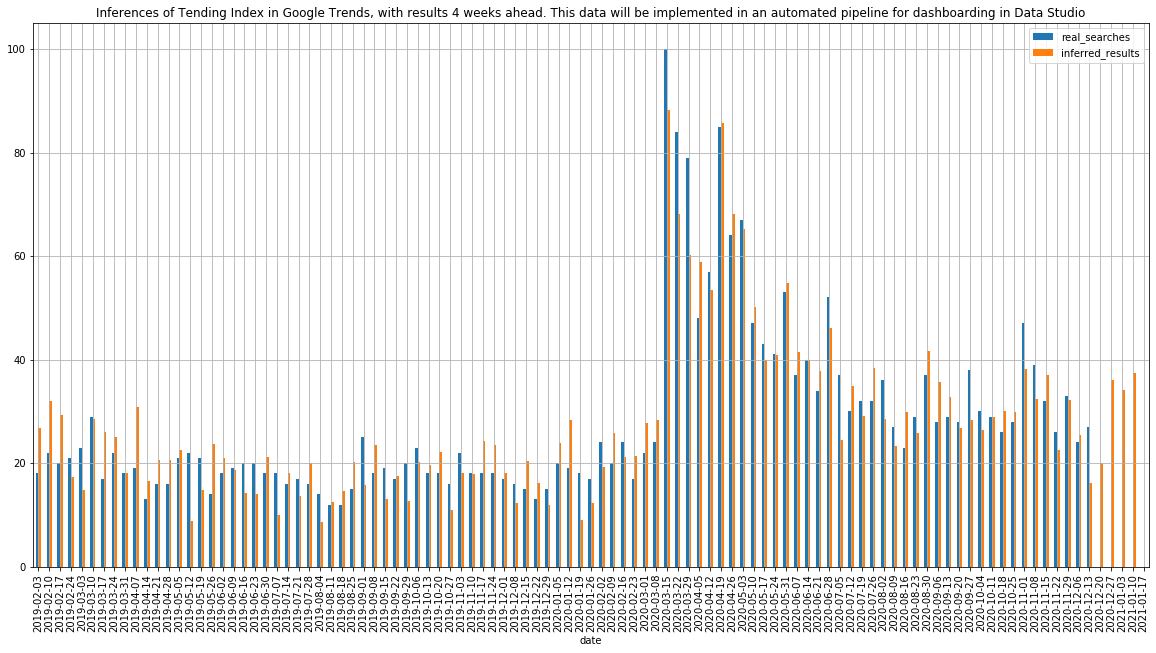

In [57]:
# visualization
result.plot(x="date",
            y=["real_searches","inferred_results"],
            figsize=(20,10), 
            kind="bar",
            title="Inferences of Tending Index in Google Trends, with results 4 weeks ahead. This data will be implemented in an automated pipeline for dashboarding in Data Studio",
            grid=True)

## CSV to append weekly the score

In [58]:
score = pd.DataFrame({"date": [max(df["date"])], 'score': [round(rfecv.score(X_train, target_train),4)]})
score.to_csv("input/weekly_score.csv")
score

,date,score
0,2021-01-17,0.8506


## CSV to overwrite weekly ranking of features by importance.

Of course there is a lot of room for improvement, but I'm glad the importance of features for the model looks coherent at first sight. Top 15 features, the ones selected by the model:

- erte = Record of Temporary Employment Regulation
- emergencia sanitaria = healthcare emegercy
- cáritas = a crhistian ONG helping the most vulnerable
- crecimiento económico = economical growth 
- videocall
- remote working
- Skype

In [59]:
# Ranking of how important are the following keywords to infer in Google searches in Spain
# the keyword "unemployment"
features=pd.DataFrame()
features["features"]=X.columns
features["top_important"]=rfecv.ranking_
features.sort_values(by=["top_important"], inplace=True)
features.reset_index(drop=True, inplace=True)
features.to_csv("input/ranking_of_features.csv")
features.head(50)
# with a linear regression the number of important features was reduced. It also had better performance.

,features,top_important
0,zoom,1
1,banco alimentos,1
2,bullying,1
3,coronavirus,1
4,corrupcion_2,1
5,embarazo,1
6,en casa,1
7,en familia,1
8,formacion,1
9,hacer deporte,1
